- WISDM dataset

  - sitting 4500  - (normal, 0)
  - running 4500  - (abnormal, 1)

- activity를 label로 설정하되 train set에서는 drop(auto encoder 기본!)

In [2]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [3]:
df = pd.read_csv("/content/drive/MyDrive/WISDM.csv", index_col=0)
df = df.drop('user-id', axis=1)
df = df.drop('timestamp', axis=1)


Sitting = df[df['activity']=='Sitting'].head(4499).copy()
Jogging = df[df['activity']=='Jogging'].head(4500).copy()


df = pd.concat([Jogging, Sitting])
df.shape

(8999, 4)

In [4]:
df['activity'].value_counts()



from sklearn.preprocessing import LabelEncoder



le=LabelEncoder()

df['activity']=le.fit_transform(df['activity'])



In [5]:
df['activity'].value_counts()

0    4500
1    4499
Name: activity, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split



X_train, X_test = train_test_split(df, test_size=0.25, random_state=42)



X_train.shape, X_test.shape

# Normal = Sitting Fall = Jogging

normal = X_train[X_train['activity'] == 1]



y_train = normal['activity']

X_train_normal_train = normal.drop(['activity'], axis=1)



y_test = X_test['activity']

X_test = X_test.drop(['activity'], axis=1)



X_train = X_train_normal_train.values

X_test = X_test.values



In [7]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [15]:
#nb_epoch = 100
nb_epoch = 10
batch_size = 32
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=(0.1),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
95/95 [==============================] - 2s 7ms/step - loss: 6.2892 - accuracy: 1.0000 - val_loss: 6.4437 - val_accuracy: 1.0000
Epoch 2/10
95/95 [==============================] - 0s 4ms/step - loss: 6.2875 - accuracy: 1.0000 - val_loss: 6.4429 - val_accuracy: 1.0000
Epoch 3/10
95/95 [==============================] - 0s 5ms/step - loss: 6.2868 - accuracy: 1.0000 - val_loss: 6.4426 - val_accuracy: 1.0000
Epoch 4/10
95/95 [==============================] - 0s 4ms/step - loss: 6.2862 - accuracy: 1.0000 - val_loss: 6.4410 - val_accuracy: 1.0000
Epoch 5/10
95/95 [==============================] - 0s 5ms/step - loss: 6.2856 - accuracy: 1.0000 - val_loss: 6.4408 - val_accuracy: 1.0000
Epoch 6/10
95/95 [==============================] - 0s 5ms/step - loss: 6.2853 - accuracy: 1.0000 - val_loss: 6.4408 - val_accuracy: 1.0000
Epoch 7/10
95/95 [==============================] - 0s 4ms/step - loss: 6.2851 - accuracy: 1.0000 - val_loss: 6.4396 - val_accuracy: 1.0000
Epoch 8/10
95/95 [==

#평가

In [16]:
autoencoder = load_model('model.h5')

In [17]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

71/71 [==============================] - 0s 3ms/step


,reconstruction_error,true_class
count,2250.000000,2250.000000
mean,21.081078,0.511111
std,26.935658,0.499988
min,0.102415,0.000000
25%,3.719433,0.000000
50%,9.508358,1.000000
75%,27.462562,1.000000
max,212.250251,1.000000


Threshold:  9.508357501793334


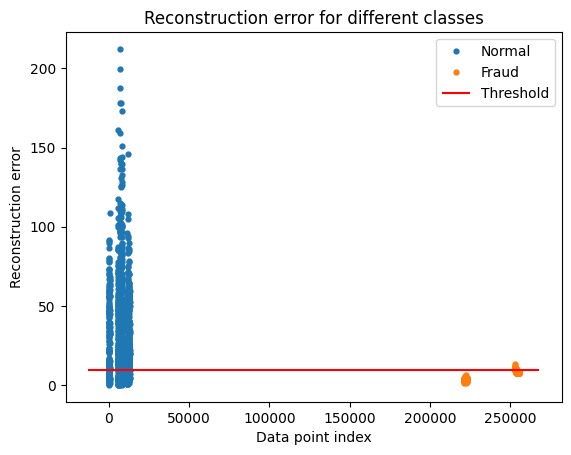

In [18]:
threshold = np.percentile(error_df.reconstruction_error.values, 50)
print("Threshold: ", threshold)


groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

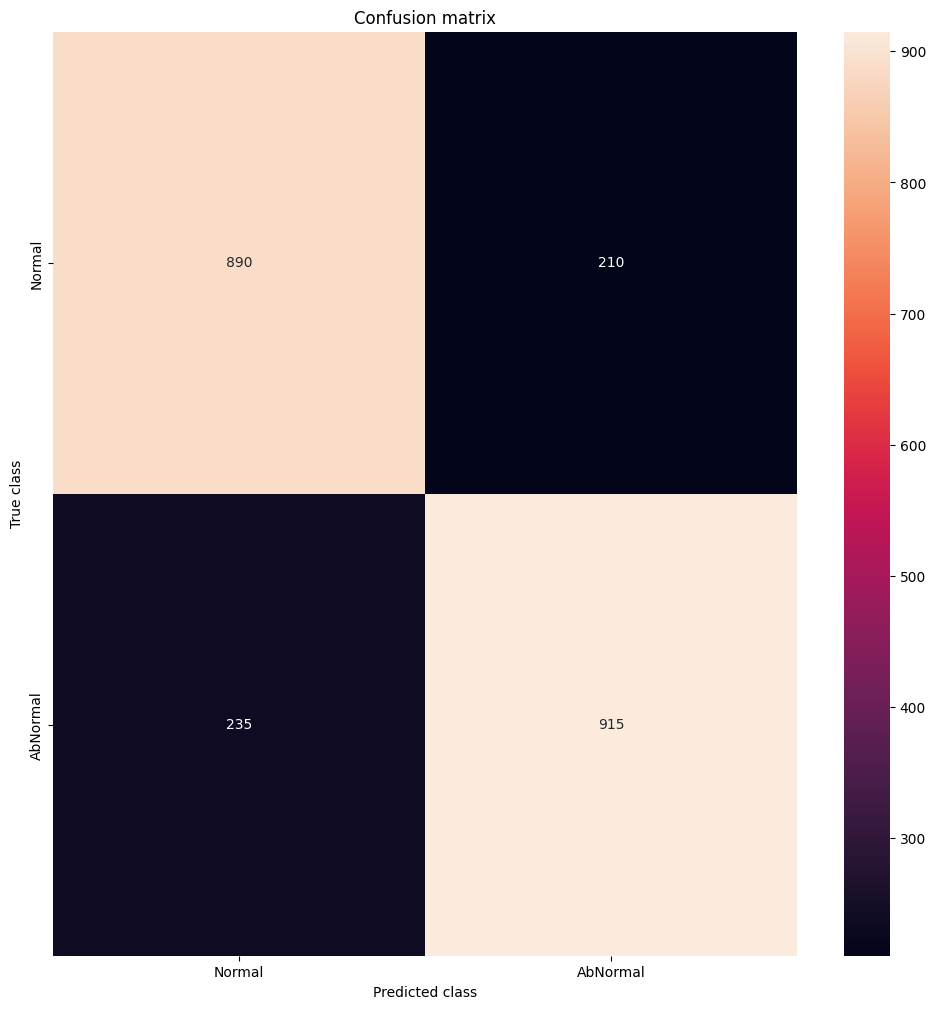

In [19]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

LABELS = ["Normal", "AbNormal"]


y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]

conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))

sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");

plt.title("Confusion matrix")

plt.ylabel('True class')

plt.xlabel('Predicted class')

plt.show()




In [20]:

from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')

print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )

print ('Precision :',precision )

print ('Recall :',recall )

print ('F1 :',f1 )

Accuracy Score : 0.8022222222222222
Precision : 0.8133333333333334
Recall : 0.7956521739130434
F1 : 0.8043956043956044
